In [4]:
import cv2 as cv
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [ ]:
# Open the thermal video stream from device 0 using the V4L backend
cap = cv.VideoCapture("/dev/video0", cv.CAP_V4L)

# Disable automatic conversion to RGB (to keep raw YUYV format)
cap.set(cv.CAP_PROP_CONVERT_RGB, 0)

# Start reading frames as long as the camera is open
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break  # Exit loop if frame capture fails

    # Split the frame vertically into two halves:
    # imdata: visual (YUYV) data, thdata: thermal data
    imdata, thdata = np.array_split(frame, 2)

    # Convert the YUYV image to BGR for visualization
    imdata = cv.cvtColor(imdata, cv.COLOR_YUV2BGR_YUYV)

    # Flip both visual and thermal images vertically for correct orientation
    imdata = cv.flip(imdata, 0)
    thdata = cv.flip(thdata, 0)

    # Extract high and low bytes of the thermal data
    high, low = cv.split(thdata)

    # Convert to raw temperature values using sensor-specific formula
    raw_temp = ((high + (low * 256)) / 64) - 273.15     # You might to adjust this formula based on your camera sensor as you would be off by a few celsius
    raw_temp = np.round(raw_temp, 2)  # Round to 2 decimal places

    # Find indices of maximum and minimum temperature in the frame
    max_idx = np.unravel_index(np.argmax(raw_temp), raw_temp.shape)
    min_idx = np.unravel_index(np.argmin(raw_temp), raw_temp.shape)

    # Extract corresponding temperature values
    max_temp = raw_temp[max_idx]
    min_temp = raw_temp[min_idx]

    # Draw circles at max and min temperature locations
    cv.circle(imdata, max_idx[::-1], 5, (0, 255, 0), -1)  # Green for max
    cv.circle(imdata, min_idx[::-1], 5, (0, 0, 255), -1)  # Red for min

    # Annotate the image with temperature values at their respective positions
    cv.putText(imdata, f'Max Temp: {max_temp:.2f}C', (max_idx[1], max_idx[0]), 
               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv.putText(imdata, f'Min Temp: {min_temp:.2f}C', (min_idx[1], min_idx[0]), 
               cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Display the annotated image
    cv.imshow('Thermal Image', imdata)

    # Wait for 1 ms and break loop if 'q' is pressed
    if cv.waitKey(1) & 0xFF == ord('q'):
        cv.destroyAllWindows()
        cap.release()
        break

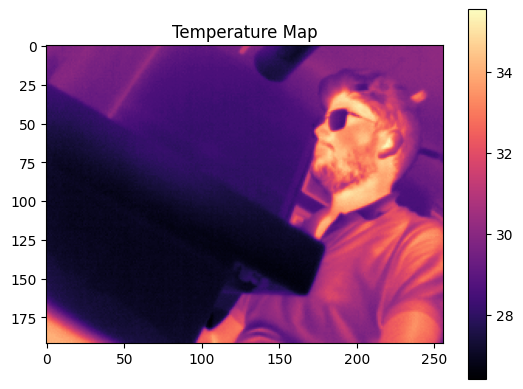

In [71]:
plt.imshow(raw_temp, cmap='magma')
plt.colorbar()
plt.title('Temperature Map')
plt.show()